<a href="https://colab.research.google.com/github/dev-SR/Deep-Learning/blob/main/04-pytorch-lighting-intro/pl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q pytorch-lightning datasets timm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.0 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader,random_split,Subset

import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.progress import TQDMProgressBar

from torchmetrics import Accuracy,F1Score

from datasets import load_dataset

import timm

import albumentations as A
from albumentations.pytorch import ToTensorV2
# ignore warning
import warnings

warnings.filterwarnings("ignore")

In [4]:
# https://www.kaggle.com/code/ayuraj/use-pytorch-lightning-with-weights-and-biases#%F0%9F%94%A7-DataModule
# https://colab.research.google.com/github/wandb/examples/blob/master/colabs/pytorch-lightning/Supercharge_your_Training_with_Pytorch_Lightning_and_Weights_and_Biases.ipynb#scrollTo=TNAWmQAJgfb0
# https://colab.research.google.com/github/PytorchLightning/lightning-tutorials/blob/publication/.notebooks/lightning_examples/cifar10-baseline.ipynb#scrollTo=c16c73b7


In [5]:
# import shutil
# shutil.rmtree("/content/lightning_logs")

In [6]:
CONFIG = dict (
    seed = 42,
    train_val_split = 0.2,
    model_name = 'resnet50',
    pretrained = True,
    img_size = 32,
    batch_size = 32,
    num_classes = 10,
    lr = 5e-4,
    min_lr = 1e-6,
    t_max = 20,
    num_epochs = 10,
    accum = 1,
    precision = 16,
    n_fold = 5,
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
)
# CONFIG = dict(
#     batch_size=32,
#     img_size=32,
#     hidden_units=(32, 16),
#     max_epochs=10,
#     gpus=1 if torch.cuda.is_available() else 0,
#     lr=0.001
# )

In [7]:
class MyDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.images = dataset["img"]
        self.labels = dataset["label"]
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            augmented = self.transform(image=np.array(image))
            image = augmented["image"]
        return {
            "image": image,
            "label": label,
        }

In [8]:
int(0.8 * 10000)

8000

In [9]:
class MnistDataModule(pl.LightningDataModule):
    def __init__(self, batch_size):
        super().__init__()
        self.batch_size = batch_size
        # Train augmentation policy
        self.train_transform = A.Compose(
            [
                A.RandomResizedCrop(
                    height=CONFIG["img_size"], width=CONFIG["img_size"]
                ),
                A.HorizontalFlip(p=0.5),
                A.ShiftScaleRotate(p=0.5),
                A.RandomBrightnessContrast(p=0.5),
                A.Normalize(),
                ToTensorV2(),
            ]
        )

        # Validation/Test augmentation policy
        self.test_transform = A.Compose(
            [
                A.Resize(height=CONFIG["img_size"], width=CONFIG["img_size"]),
                A.Normalize(),
                ToTensorV2(),
            ]
        )

    def prepare_data(self):
        self.full_train_ds, self.test_ds = load_dataset(
            "cifar10", split=["train[:5000]", "test[:1000]"]
        )
        split_index = int(0.8 * len(self.full_train_ds))

        # Splitting the full training dataset into train and validation
        self.train_ds = self.full_train_ds[:split_index]
        self.valid_ds = self.full_train_ds[split_index:]

    def setup(self, stage=None):
        self.train = MyDataset(self.train_ds, self.train_transform)
        self.valid = MyDataset(self.valid_ds, self.test_transform)
        self.test = MyDataset(self.test_ds, self.test_transform)

    def train_dataloader(self):
        return DataLoader(
            self.train,
            batch_size=self.batch_size,
            num_workers=4,
            shuffle=True,
            )

    def val_dataloader(self):
        return DataLoader(
            self.valid,
            batch_size=self.batch_size,
            num_workers=4,
            )

    def test_dataloader(self):
        return DataLoader(
            self.test,
            batch_size=self.batch_size,
            num_workers=4,
            )
datamodule = MnistDataModule(batch_size=CONFIG["batch_size"])
datamodule.prepare_data()
datamodule.setup()
# Samples required by the custom ImagePredictionLogger callback to log image predictions.
val_samples = next(iter(datamodule.val_dataloader()))
val_imgs, val_labels = val_samples["image"], val_samples["label"]
val_imgs.shape, val_labels.shape

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

(torch.Size([32, 3, 32, 32]), torch.Size([32]))

In [10]:
class CustomResNet(nn.Module):
    def __init__(self, model_name='resnet18', pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        in_features = self.model.get_classifier().in_features
        self.model.fc = nn.Linear(in_features, CONFIG['num_classes'])

    def forward(self, x):
        x = self.model(x)
        return x

In [11]:
class LitModule(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.lr = CONFIG['lr']
        self.loss_fn = nn.CrossEntropyLoss()
        self.f1_score =F1Score(task="multiclass", num_classes=10)
        self.accuracy = Accuracy(task="multiclass", num_classes=10)

        self.model = CustomResNet()

    def forward(self, x):
        x = self.model(x)
        return x

In [12]:
log_params = dict(on_step=False, on_epoch=True, prog_bar=True, logger=True,enable_graph=True)

def evaluate(self, batch, stage=None):
    # x, y = batch
    x = batch['image']
    y = batch['label']
    logits = self.model(x)
    loss = self.loss_fn(logits, y)
    preds = torch.argmax(logits, 1)
    acc = self.accuracy(preds, y)
    f1 = self.f1_score(preds, y)
        # logging metrics we calculated by hand
    logs = {f"{stage}_loss": loss, f"{stage}_f1": f1,f"{stage}_acc":acc}
    self.log_dict(logs,**log_params)
    return loss

def training_step(self, batch, batch_idx):
    return evaluate(self, batch, stage='train')

def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                           T_max=CONFIG['t_max'],
                                                           eta_min=CONFIG['min_lr'],
                                                           verbose=True)
    return {'optimizer': optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "train_loss"}
            }


def validation_step(self, batch, batch_idx):
    self.evaluate(batch, "val")

def test_step(self, batch, batch_idx):
    self.evaluate(batch, "test")


LitModule.evaluate = evaluate
LitModule.training_step = training_step
LitModule.validation_step = validation_step
LitModule.test_step = test_step
LitModule.configure_optimizers = configure_optimizers

In [18]:
model = LitModule()
trainer = pl.Trainer(max_epochs=3,
                     logger=CSVLogger(save_dir="logs/"),
                     callbacks=[LearningRateMonitor(logging_interval="step"),
                               TQDMProgressBar(refresh_rate=10)]
                     )
trainer.fit(model=model, datamodule=datamodule)
trainer.validate(model=model, datamodule=datamodule)
trainer.test(model=model, datamodule=datamodule)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type               | Params
------------------------------------------------
0 | loss_fn  | CrossEntropyLoss   | 0     
1 | f1_score | MulticlassF1Score  | 0     
2 | accuracy | MulticlassAccuracy | 0     
3 | model    | CustomResNet       | 11.2 M
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)


Adjusting learning rate of group 0 to 5.0000e-04.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.9693e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.8779e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.7281e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.3479999899864197     │
│          val_f1           │    0.3479999899864197     │
│         val_loss          │    1.8208508491516113     │
└───────────────────────────┴───────────────────────────┘

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.3230000138282776     │
│          test_f1          │    0.3230000138282776     │
│         test_loss         │     1.813183069229126     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.813183069229126,
  'test_f1': 0.3230000138282776,
  'test_acc': 0.3230000138282776}]

logs/lightning_logs/version_3


,lr-Adam,step,val_loss,epoch,val_acc,val_f1,train_loss,train_acc,train_f1,test_loss,test_f1,test_acc
0,0.000500,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000500,99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,124,2.134001,0.0,0.199,0.199,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,124,NaN,0.0,NaN,NaN,2.186347,0.1785,0.1785,NaN,NaN,NaN
4,0.000497,149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,val_loss,val_acc,val_f1,train_loss,train_acc,train_f1,test_loss,test_f1,test_acc
epoch,,,,,,,,,
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.0,2.134001,0.199,0.199,NaN,NaN,NaN,NaN,NaN,NaN
0.0,NaN,NaN,NaN,2.186347,0.1785,0.1785,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


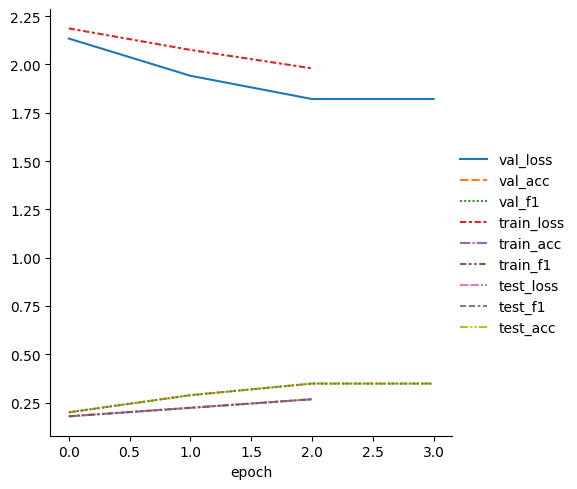

In [25]:
import seaborn as sns
log_dir = trainer.logger.log_dir
print(log_dir)

metrics = pd.read_csv(f"{log_dir}/metrics.csv")
display(metrics.head())
metrics.drop(columns=['step','lr-Adam'],inplace=True)

metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())

sns.relplot(data=metrics, kind="line")